In [ ]:
# === notebook_backbone_sweep_late.py ===
import os, time, random, sys, argparse
import numpy as np
import pandas as pd
from tqdm import tqdm

import torch
from torch.amp import autocast, GradScaler
import torch.nn as nn
from sklearn.metrics import roc_auc_score

from dataloader import get_dataloaders
from late_fusion_multibackbone import LateFusionClassifier


# -----------------------------
# Utilities
# -----------------------------
def set_global_seed(seed: int = 1337):
    os.environ["PYTHONHASHSEED"] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


def masked_macro_auroc(y_true_np, y_prob_np):
    mask = (y_true_np != -1)
    C = y_true_np.shape[1]
    scores = []
    for c in range(C):
        m = mask[:, c]
        if m.sum() == 0:
            continue
        yt = y_true_np[m].astype(np.int32)[:, c]
        yp = y_prob_np[m][:, c]
        if yt.max() == yt.min():
            continue
        scores.append(roc_auc_score(yt, yp))
    return float(np.mean(scores)) if scores else float("nan")


def masked_flat_auroc(y_true_np, y_prob_np):
    mask = (y_true_np != -1)
    yt = y_true_np[mask].astype(np.int32)
    yp = y_prob_np[mask]
    return float(roc_auc_score(yt, yp))


# --- helper: fully freeze/unfreeze the CXR backbone, including BN stats (optional warmup) ---
def set_cxr_frozen(model: LateFusionClassifier, freeze: bool):
    # stop/start gradients on all CXR params
    for p in model.cxr_encoder.parameters():
        p.requires_grad = not freeze
    # freeze BN running stats while frozen
    for m in model.cxr_encoder.modules():
        if isinstance(m, (nn.BatchNorm2d, nn.SyncBatchNorm)):
            if freeze:
                m.eval(); m.track_running_stats = False
            else:
                m.train(); m.track_running_stats = True
    # keep feature extractor in eval when frozen
    model.cxr_encoder.train(not freeze)


# -----------------------------
# Backbone training defaults (LR scale & freeze warmup like Adaptive/Early)
# -----------------------------
BACKBONE_DEFAULTS = {
    "resnet50":        dict(backbone_lr_scale=0.30, freeze_cxr_epochs=1),
    "densenet121":     dict(backbone_lr_scale=0.30, freeze_cxr_epochs=1),
    "efficientnet_b2": dict(backbone_lr_scale=0.08, freeze_cxr_epochs=2),
    "convnext_tiny":   dict(backbone_lr_scale=0.10, freeze_cxr_epochs=2),
    "vgg16_bn":        dict(backbone_lr_scale=0.30, freeze_cxr_epochs=1),
}
SUPPORTED_BACKBONES = set(BACKBONE_DEFAULTS.keys())


# -----------------------------
# Train one backbone (LATE FUSION)
# -----------------------------
def train_one_backbone(
    cxr_backbone: str,
    data_dir: str,
    save_dir: str,
    device,
    n_epochs=30,
    batch_size=16,
    num_workers=4,
    lr=1e-4,
    weight_decay=1e-5,
    lab_input_dim=100,
    use_amp=True,
    # overrides (None → use defaults)
    backbone_lr_scale=None,
    freeze_cxr_epochs=None,
):
    if cxr_backbone not in SUPPORTED_BACKBONES:
        raise ValueError(f"Backbone '{cxr_backbone}' not supported. Choose from {sorted(SUPPORTED_BACKBONES)}.")

    os.makedirs(save_dir, exist_ok=True)
    per_epoch_csv = os.path.join(save_dir, f"gate_trends_{cxr_backbone}.csv")  # keep name for plotting compatibility
    ckpt_path     = os.path.join(save_dir, f"late_fusion_{cxr_backbone}.pt")

    # ---- merge defaults with overrides ----
    cfg = {**BACKBONE_DEFAULTS[cxr_backbone]}
    if backbone_lr_scale is not None: cfg["backbone_lr_scale"] = float(backbone_lr_scale)
    if freeze_cxr_epochs is not None: cfg["freeze_cxr_epochs"] = int(freeze_cxr_epochs)

    # ---- data ----
    train_loader, val_loader, test_loader = get_dataloaders(
        data_dir, batch_size=batch_size, num_workers=num_workers
    )

    # ---- model ----
    model = LateFusionClassifier(
        num_classes=14,
        lr=lr,
        lab_input_dim=lab_input_dim,
        cxr_backbone=cxr_backbone,
    ).to(device)

    # ---- optimizer with smaller LR for backbone ----
    backbone_params = list(model.cxr_encoder.parameters())
    other_params = [p for n, p in model.named_parameters()
                    if p.requires_grad and not n.startswith("cxr_encoder.")]

    optimizer = torch.optim.Adam(
        [{"params": other_params,   "lr": lr},
         {"params": backbone_params, "lr": lr * cfg["backbone_lr_scale"]}],
        weight_decay=weight_decay
    )
    BACKBONE_GROUP_IDX = 1

    scaler = GradScaler(device="cuda", enabled=(use_amp and torch.cuda.is_available()))

    # ---- tracking ----
    best_val_auroc = -1.0
    total_train_sec = 0.0
    peak_gpu_overall = 0.0
    epoch_rows = []

    # ---- training loop ----
    for epoch in range(n_epochs):
        model.train()

        # optional: freeze CXR at start to avoid instant dominance
        freeze_now = epoch < int(cfg["freeze_cxr_epochs"])
        set_cxr_frozen(model, freeze_now)
        optimizer.param_groups[BACKBONE_GROUP_IDX]["lr"] = (
            0.0 if freeze_now else lr * cfg["backbone_lr_scale"]
        )

        if torch.cuda.is_available():
            torch.cuda.reset_peak_memory_stats()
        ep_t0 = time.perf_counter()

        train_loss_sum = 0.0
        y_true_train, y_prob_train = [], []

        for cxr, ecg, labs, y in tqdm(train_loader, desc=f"[{cxr_backbone}] Train {epoch+1}/{n_epochs}", leave=False):
            cxr  = cxr.to(device).float()
            labs = labs.to(device).float()
            y    = y.to(device)

            # ECG to (B,12,T)
            ecg = ecg.to(device).float()
            if ecg.ndim == 4 and ecg.shape[1] == 1:
                ecg = ecg.squeeze(1)
            if ecg.shape[1] != 12 and ecg.shape[-1] == 12:
                ecg = ecg.permute(0, 2, 1)

            optimizer.zero_grad(set_to_none=True)
            with autocast(device_type="cuda", enabled=(use_amp and torch.cuda.is_available())):
                logits = model(cxr, ecg, labs)                # late fusion has no gates
                loss = model.masked_bce_loss(logits, y)

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            train_loss_sum += float(loss.item())
            with torch.no_grad():
                y_prob_train.append(torch.sigmoid(logits).cpu().numpy())
                y_true_train.append(y.cpu().numpy())

        y_prob_train = np.concatenate(y_prob_train)
        y_true_train = np.concatenate(y_true_train)
        train_auroc = masked_macro_auroc(y_true_train, y_prob_train)
        avg_train_loss = train_loss_sum / max(1, len(train_loader))

        # ---- validation ----
        model.eval()
        val_loss_sum = 0.0
        y_true_val, y_prob_val = [], []

        with torch.no_grad():
            for cxr, ecg, labs, y in tqdm(val_loader, desc=f"[{cxr_backbone}] Val {epoch+1}/{n_epochs}", leave=False):
                cxr  = cxr.to(device).float()
                labs = labs.to(device).float()
                y    = y.to(device)

                ecg = ecg.to(device).float()
                if ecg.ndim == 4 and ecg.shape[1] == 1:
                    ecg = ecg.squeeze(1)
                if ecg.shape[1] != 12 and ecg.shape[-1] == 12:
                    ecg = ecg.permute(0, 2, 1)

                logits = model(cxr, ecg, labs)
                loss = model.masked_bce_loss(logits, y)
                val_loss_sum += float(loss.item())

                y_prob_val.append(torch.sigmoid(logits).cpu().numpy())
                y_true_val.append(y.cpu().numpy())

        y_prob_val = np.concatenate(y_prob_val)
        y_true_val = np.concatenate(y_true_val)

        val_auroc_macro = masked_macro_auroc(y_true_val, y_prob_val)
        val_auroc_flat  = masked_flat_auroc(y_true_val, y_prob_val)

        # ---- epoch timing & memory ----
        ep_time = time.perf_counter() - ep_t0
        total_train_sec += ep_time
        peak_mem_gb = (torch.cuda.max_memory_allocated() / 1e9) if torch.cuda.is_available() else 0.0
        peak_gpu_overall = max(peak_gpu_overall, peak_mem_gb)

        print(f"[{cxr_backbone}] Epoch {epoch+1}/{n_epochs} | "
              f"TrainLoss {avg_train_loss:.4f} | TrainAUC {train_auroc:.4f} | "
              f"ValLoss {val_loss_sum/len(val_loader):.4f} | "
              f"ValAUC_macro {val_auroc_macro:.4f} | ValAUC_flat {val_auroc_flat:.4f} | "
              f"{ep_time:.1f}s | Peak {peak_mem_gb:.2f} GB")

        # save best
        if val_auroc_macro > best_val_auroc:
            best_val_auroc = val_auroc_macro
            torch.save(model.state_dict(), ckpt_path)
            print(f"  Saved best @ epoch {epoch+1}: {best_val_auroc:.4f} → {ckpt_path}")

        # write per‑epoch row (gate_* are NaN to keep plotting compatible)
        epoch_rows.append({
            "epoch": epoch+1,
            "train_loss": avg_train_loss,
            "val_loss": val_loss_sum/len(val_loader),
            "train_auroc_macro": train_auroc,
            "val_auroc_macro": val_auroc_macro,
            "val_auroc_flat": val_auroc_flat,
            "gate_ecg": np.nan,
            "gate_cxr": np.nan,
            "gate_labs": np.nan,
            "epoch_sec": ep_time,
            "peak_mem_GB": peak_mem_gb,
        })
        pd.DataFrame(epoch_rows).to_csv(per_epoch_csv, index=False)

    # --- After training finished for this backbone: PRINT totals & save CUDA memory summary ---
    print(f"\n[FINISHED TRAINING] {cxr_backbone} | total_train_sec={total_train_sec:.1f}s | "
          f"overall_train_peak_gpu={peak_gpu_overall:.2f} GB")
    if torch.cuda.is_available():
        mem_txt = os.path.join(save_dir, f"memory_summary_train_{cxr_backbone}.txt")
        with open(mem_txt, "w") as f:
            f.write(torch.cuda.memory_summary(device=device, abbreviated=True))
        print(f"Saved CUDA memory summary → {mem_txt}")

    # --- Test evaluation with timing & peak GPU ---
    state = torch.load(ckpt_path, map_location=device)
    model.load_state_dict(state)
    model.eval()

    if torch.cuda.is_available():
        torch.cuda.reset_peak_memory_stats()
    t0 = time.perf_counter()
    _, _, test_loader = get_dataloaders(data_dir, batch_size=batch_size, num_workers=num_workers)
    test_probs, test_targets = [], []
    with torch.no_grad():
        for cxr, ecg, labs, y in tqdm(test_loader, desc=f"[{cxr_backbone}] Test", leave=False):
            cxr  = cxr.to(device).float()
            labs = labs.to(device).float()
            y    = y.to(device)

            ecg = ecg.to(device).float()
            if ecg.ndim == 4 and ecg.shape[1] == 1:
                ecg = ecg.squeeze(1)
            if ecg.shape[1] != 12 and ecg.shape[-1] == 12:
                ecg = ecg.permute(0, 2, 1)

            logits = model(cxr, ecg, labs)
            test_probs.append(torch.sigmoid(logits).cpu().numpy())
            test_targets.append(y.cpu().numpy())
    test_elapsed = time.perf_counter() - t0
    test_peak_gb = (torch.cuda.max_memory_allocated() / 1e9) if torch.cuda.is_available() else 0.0

    test_probs   = np.concatenate(test_probs)
    test_targets = np.concatenate(test_targets)
    test_macro = masked_macro_auroc(test_targets, test_probs)
    test_flat  = masked_flat_auroc(test_targets, test_probs)

    # print eval stats quickly too
    print(f"[EVAL DONE] {cxr_backbone} | test_macro_auc={test_macro:.4f} | "
          f"test_flat_auc={test_flat:.4f} | eval_sec={test_elapsed:.1f}s | "
          f"eval_peak_gpu={test_peak_gb:.2f} GB")

    return {
        "model_type": "late",
        "backbone": cxr_backbone,
        "best_val_macro_auc": float(best_val_auroc),
        "test_macro_auc": float(test_macro),
        "test_flat_auc": float(test_flat),
        "train_total_sec": float(total_train_sec),
        "train_avg_epoch_sec": float(total_train_sec / max(1, len(epoch_rows))),
        "train_peak_gpu_GB": float(peak_gpu_overall),
        "test_eval_sec": float(test_elapsed),
        "test_peak_gpu_GB": float(test_peak_gb),
        "checkpoint": os.path.abspath(ckpt_path),
        "per_epoch_csv": os.path.abspath(per_epoch_csv),
    }


# -----------------------------
# Sweep wrapper
# -----------------------------
def run_backbone_sweep(
    data_dir,
    save_dir="./checkpoints",
    backbones=("resnet50", "densenet121", "efficientnet_b2", "convnext_tiny", "vgg16_bn"),
    epochs=30,
    batch_size=16,
    num_workers=4,
    seed=1337,
    overrides=None,  # dict[str, dict] e.g., {"resnet50": {"freeze_cxr_epochs":2}}
    lr=1e-4,
    weight_decay=1e-5,
    use_amp=True,
    lab_input_dim=100,
):
    set_global_seed(seed)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    os.makedirs(save_dir, exist_ok=True)

    summary = []
    for b in backbones:
        if b not in SUPPORTED_BACKBONES:
            print(f"[skip] Backbone '{b}' not supported; choose from {sorted(SUPPORTED_BACKBONES)}")
            continue
        print("\n" + "="*80)
        print(f"[LATE FUSION] Training backbone: {b}")
        print("="*80)

        kw = (overrides or {}).get(b, {})
        res = train_one_backbone(
            cxr_backbone=b,
            data_dir=data_dir,
            save_dir=save_dir,
            device=device,
            n_epochs=epochs,
            batch_size=batch_size,
            num_workers=num_workers,
            lr=lr,
            weight_decay=weight_decay,
            lab_input_dim=lab_input_dim,
            use_amp=use_amp,
            **kw,
        )
        summary.append(res)

    df = pd.DataFrame(summary)
    out_csv = os.path.join(save_dir, "late_backbone_sweep_summary.csv")
    df.to_csv(out_csv, index=False)

    print("\n=== Late Fusion — Sweep Summary ===")
    if not df.empty:
        print(df.round(4).to_string(index=False))
        print(f"\nSaved summary → {out_csv}")
    else:
        print("No runs executed (empty).")
    return df


# ----------------------------
# Optional CLI entry 
# -----------------------------
def _cli():
    ap = argparse.ArgumentParser()
    ap.add_argument("--data_dir", type=str, default="/data/mahjabeen_workspace/Summer25_Project/symile/new_experiment/symile_fusion_classification/data/processed_pt_correctedV2")
    ap.add_argument("--save_dir", type=str, default="./checkpoints")
    ap.add_argument("--backbones", type=str, nargs="+",
                    default=["resnet50", "densenet121", "efficientnet_b2", "convnext_tiny", "vgg16_bn"])
    ap.add_argument("--epochs", type=int, default=30)
    ap.add_argument("--batch_size", type=int, default=16)
    ap.add_argument("--num_workers", type=int, default=4)
    ap.add_argument("--seed", type=int, default=1337)
    ap.add_argument("--lr", type=float, default=1e-4)
    ap.add_argument("--weight_decay", type=float, default=1e-5)
    ap.add_argument("--lab_input_dim", type=int, default=100)
    ap.add_argument("--no_amp", action="store_true")
    args, _unknown = ap.parse_known_args(sys.argv[1:])

    run_backbone_sweep(
        data_dir=args.data_dir,
        save_dir=args.save_dir,
        backbones=args.backbones,
        epochs=args.epochs,
        batch_size=args.batch_size,
        num_workers=args.num_workers,
        seed=args.seed,
        lr=args.lr,
        weight_decay=args.weight_decay,
        use_amp=not args.no_amp,
        lab_input_dim=args.lab_input_dim,
        overrides=None,
    )


if __name__ == "__main__":
    _cli()


/data/mahjabeen_workspace/Summer25_Project/symile/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm



[LATE FUSION] Training backbone: resnet50


[resnet50] Epoch 1/30 | TrainLoss 0.4473 | TrainAUC 0.4912 | ValLoss 0.4293 | ValAUC_macro 0.5882 | ValAUC_flat 0.8455 | 25.7s | Peak 0.49 GB
  Saved best @ epoch 1: 0.5882 → ./checkpoints/late_fusion_resnet50.pt


[resnet50] Epoch 2/30 | TrainLoss 0.4385 | TrainAUC 0.4784 | ValLoss 0.4290 | ValAUC_macro 0.5712 | ValAUC_flat 0.8429 | 46.0s | Peak 1.86 GB


[resnet50] Epoch 3/30 | TrainLoss 0.4333 | TrainAUC 0.5037 | ValLoss 0.4828 | ValAUC_macro 0.5115 | ValAUC_flat 0.8466 | 46.6s | Peak 1.86 GB


[resnet50] Epoch 4/30 | TrainLoss 0.4312 | TrainAUC 0.5302 | ValLoss 0.4287 | ValAUC_macro 0.5225 | ValAUC_flat 0.8454 | 46.9s | Peak 1.86 GB


[resnet50] Epoch 5/30 | TrainLoss 0.4294 | TrainAUC 0.5553 | ValLoss 0.4258 | ValAUC_macro 0.5676 | ValAUC_flat 0.8464 | 47.3s | Peak 1.86 GB


[resnet50] Epoch 6/30 | TrainLoss 0.4267 | TrainAUC 0.5970 | ValLoss 0.4317 | ValAUC_macro 0.5782 | ValAUC_flat 0.8449 | 47.0s | Peak 1.86 GB


[resnet50] Epoch 7/30 | TrainLoss 0.4180 | TrainAUC 0.6650 | ValLoss 0.4484 | ValAUC_macro 0.5865 | ValAUC_flat 0.8372 | 47.5s | Peak 1.86 GB


[resnet50] Epoch 8/30 | TrainLoss 0.3953 | TrainAUC 0.7508 | ValLoss 0.4605 | ValAUC_macro 0.5504 | ValAUC_flat 0.8443 | 47.6s | Peak 1.86 GB


[resnet50] Epoch 9/30 | TrainLoss 0.3629 | TrainAUC 0.8024 | ValLoss 0.6358 | ValAUC_macro 0.5405 | ValAUC_flat 0.8380 | 47.7s | Peak 1.86 GB


[resnet50] Epoch 10/30 | TrainLoss 0.3279 | TrainAUC 0.8456 | ValLoss 0.5039 | ValAUC_macro 0.5611 | ValAUC_flat 0.8426 | 47.9s | Peak 1.86 GB


[resnet50] Epoch 11/30 | TrainLoss 0.3005 | TrainAUC 0.8723 | ValLoss 0.9410 | ValAUC_macro 0.4958 | ValAUC_flat 0.8381 | 47.7s | Peak 1.86 GB


[resnet50] Epoch 12/30 | TrainLoss 0.2767 | TrainAUC 0.8867 | ValLoss 1.5061 | ValAUC_macro 0.4916 | ValAUC_flat 0.8236 | 47.1s | Peak 1.86 GB


[resnet50] Epoch 13/30 | TrainLoss 0.2655 | TrainAUC 0.9078 | ValLoss 0.8257 | ValAUC_macro 0.4771 | ValAUC_flat 0.8212 | 46.7s | Peak 1.86 GB


[resnet50] Epoch 14/30 | TrainLoss 0.2470 | TrainAUC 0.9199 | ValLoss 0.7367 | ValAUC_macro 0.4938 | ValAUC_flat 0.8288 | 46.4s | Peak 1.86 GB


[resnet50] Epoch 15/30 | TrainLoss 0.2311 | TrainAUC 0.9247 | ValLoss 0.6356 | ValAUC_macro 0.5078 | ValAUC_flat 0.7909 | 46.7s | Peak 1.86 GB


[resnet50] Epoch 16/30 | TrainLoss 0.2116 | TrainAUC 0.9345 | ValLoss 0.7294 | ValAUC_macro 0.5241 | ValAUC_flat 0.7867 | 46.5s | Peak 1.86 GB


[resnet50] Epoch 17/30 | TrainLoss 0.1889 | TrainAUC 0.9494 | ValLoss 0.6485 | ValAUC_macro 0.5251 | ValAUC_flat 0.7811 | 46.8s | Peak 1.86 GB


[resnet50] Epoch 18/30 | TrainLoss 0.1741 | TrainAUC 0.9511 | ValLoss 0.7962 | ValAUC_macro 0.5385 | ValAUC_flat 0.7962 | 46.6s | Peak 1.86 GB


[resnet50] Epoch 19/30 | TrainLoss 0.1669 | TrainAUC 0.9598 | ValLoss 0.7107 | ValAUC_macro 0.4894 | ValAUC_flat 0.7691 | 46.6s | Peak 1.86 GB


[resnet50] Epoch 20/30 | TrainLoss 0.1551 | TrainAUC 0.9647 | ValLoss 0.8769 | ValAUC_macro 0.4789 | ValAUC_flat 0.7937 | 46.7s | Peak 1.86 GB


[resnet50] Epoch 21/30 | TrainLoss 0.1462 | TrainAUC 0.9723 | ValLoss 1.0823 | ValAUC_macro 0.5096 | ValAUC_flat 0.8377 | 46.7s | Peak 1.86 GB


[resnet50] Epoch 22/30 | TrainLoss 0.1355 | TrainAUC 0.9670 | ValLoss 0.9279 | ValAUC_macro 0.4977 | ValAUC_flat 0.8222 | 46.8s | Peak 1.86 GB


[resnet50] Epoch 23/30 | TrainLoss 0.1204 | TrainAUC 0.9809 | ValLoss 0.8551 | ValAUC_macro 0.4997 | ValAUC_flat 0.7997 | 46.6s | Peak 1.86 GB


[resnet50] Epoch 24/30 | TrainLoss 0.1148 | TrainAUC 0.9781 | ValLoss 1.0440 | ValAUC_macro 0.5301 | ValAUC_flat 0.7973 | 46.7s | Peak 1.86 GB


[resnet50] Epoch 25/30 | TrainLoss 0.1063 | TrainAUC 0.9778 | ValLoss 1.2178 | ValAUC_macro 0.4840 | ValAUC_flat 0.8139 | 46.7s | Peak 1.86 GB


[resnet50] Epoch 26/30 | TrainLoss 0.0985 | TrainAUC 0.9837 | ValLoss 0.9128 | ValAUC_macro 0.5279 | ValAUC_flat 0.7971 | 46.4s | Peak 1.86 GB


[resnet50] Epoch 27/30 | TrainLoss 0.0918 | TrainAUC 0.9820 | ValLoss 1.2042 | ValAUC_macro 0.5103 | ValAUC_flat 0.8116 | 46.3s | Peak 1.86 GB


[resnet50] Epoch 28/30 | TrainLoss 0.0870 | TrainAUC 0.9832 | ValLoss 1.1744 | ValAUC_macro 0.5053 | ValAUC_flat 0.8169 | 46.8s | Peak 1.86 GB


[resnet50] Epoch 29/30 | TrainLoss 0.0819 | TrainAUC 0.9865 | ValLoss 0.8851 | ValAUC_macro 0.5599 | ValAUC_flat 0.7631 | 46.9s | Peak 1.86 GB


[resnet50] Epoch 30/30 | TrainLoss 0.0783 | TrainAUC 0.9883 | ValLoss 1.3756 | ValAUC_macro 0.4891 | ValAUC_flat 0.8184 | 46.7s | Peak 1.86 GB

[FINISHED TRAINING] resnet50 | total_train_sec=1384.9s | overall_train_peak_gpu=1.86 GB
Saved CUDA memory summary → ./checkpoints/memory_summary_train_resnet50.txt


[EVAL DONE] resnet50 | test_macro_auc=0.5158 | test_flat_auc=0.8219 | eval_sec=14.6s | eval_peak_gpu=0.88 GB

[LATE FUSION] Training backbone: densenet121


[densenet121] Epoch 1/30 | TrainLoss 0.4497 | TrainAUC 0.4857 | ValLoss 0.4292 | ValAUC_macro 0.5920 | ValAUC_flat 0.8471 | 27.5s | Peak 0.41 GB
  Saved best @ epoch 1: 0.5920 → ./checkpoints/late_fusion_densenet121.pt


[densenet121] Epoch 2/30 | TrainLoss 0.4360 | TrainAUC 0.5129 | ValLoss 0.4329 | ValAUC_macro 0.5340 | ValAUC_flat 0.8419 | 55.2s | Peak 2.34 GB


[densenet121] Epoch 3/30 | TrainLoss 0.4321 | TrainAUC 0.5403 | ValLoss 0.4288 | ValAUC_macro 0.5422 | ValAUC_flat 0.8488 | 55.0s | Peak 2.34 GB


[densenet121] Epoch 4/30 | TrainLoss 0.4293 | TrainAUC 0.5590 | ValLoss 0.4280 | ValAUC_macro 0.5556 | ValAUC_flat 0.8444 | 55.3s | Peak 2.34 GB


[densenet121] Epoch 5/30 | TrainLoss 0.4209 | TrainAUC 0.6275 | ValLoss 0.4425 | ValAUC_macro 0.5656 | ValAUC_flat 0.8443 | 55.4s | Peak 2.34 GB


[densenet121] Epoch 6/30 | TrainLoss 0.3989 | TrainAUC 0.7232 | ValLoss 0.4370 | ValAUC_macro 0.5564 | ValAUC_flat 0.8412 | 55.4s | Peak 2.34 GB


[densenet121] Epoch 7/30 | TrainLoss 0.3638 | TrainAUC 0.7972 | ValLoss 0.5659 | ValAUC_macro 0.5374 | ValAUC_flat 0.8373 | 55.9s | Peak 2.34 GB


[densenet121] Epoch 8/30 | TrainLoss 0.3209 | TrainAUC 0.8552 | ValLoss 0.5500 | ValAUC_macro 0.5106 | ValAUC_flat 0.7652 | 55.4s | Peak 2.34 GB


[densenet121] Epoch 9/30 | TrainLoss 0.2736 | TrainAUC 0.8925 | ValLoss 0.6668 | ValAUC_macro 0.4980 | ValAUC_flat 0.7763 | 55.8s | Peak 2.34 GB


[densenet121] Epoch 10/30 | TrainLoss 0.2211 | TrainAUC 0.9248 | ValLoss 0.5894 | ValAUC_macro 0.5558 | ValAUC_flat 0.8103 | 55.6s | Peak 2.34 GB


[densenet121] Epoch 11/30 | TrainLoss 0.1830 | TrainAUC 0.9450 | ValLoss 0.7147 | ValAUC_macro 0.5215 | ValAUC_flat 0.8200 | 55.7s | Peak 2.34 GB


[densenet121] Epoch 12/30 | TrainLoss 0.1517 | TrainAUC 0.9494 | ValLoss 0.7775 | ValAUC_macro 0.5578 | ValAUC_flat 0.6770 | 55.7s | Peak 2.34 GB


[densenet121] Epoch 13/30 | TrainLoss 0.1280 | TrainAUC 0.9679 | ValLoss 0.7868 | ValAUC_macro 0.5240 | ValAUC_flat 0.7733 | 55.4s | Peak 2.34 GB


[densenet121] Epoch 14/30 | TrainLoss 0.1055 | TrainAUC 0.9719 | ValLoss 0.8196 | ValAUC_macro 0.5364 | ValAUC_flat 0.7349 | 55.5s | Peak 2.34 GB


[densenet121] Epoch 15/30 | TrainLoss 0.0933 | TrainAUC 0.9750 | ValLoss 0.9944 | ValAUC_macro 0.5407 | ValAUC_flat 0.6569 | 55.7s | Peak 2.34 GB


[densenet121] Epoch 16/30 | TrainLoss 0.0807 | TrainAUC 0.9819 | ValLoss 0.9093 | ValAUC_macro 0.5808 | ValAUC_flat 0.7596 | 55.8s | Peak 2.34 GB


[densenet121] Epoch 17/30 | TrainLoss 0.0708 | TrainAUC 0.9858 | ValLoss 1.3414 | ValAUC_macro 0.5202 | ValAUC_flat 0.7968 | 55.5s | Peak 2.34 GB


[densenet121] Epoch 18/30 | TrainLoss 0.0705 | TrainAUC 0.9844 | ValLoss 1.1243 | ValAUC_macro 0.5620 | ValAUC_flat 0.6292 | 55.5s | Peak 2.34 GB


[densenet121] Epoch 19/30 | TrainLoss 0.0627 | TrainAUC 0.9849 | ValLoss 0.9208 | ValAUC_macro 0.5407 | ValAUC_flat 0.7074 | 55.3s | Peak 2.34 GB


[densenet121] Epoch 20/30 | TrainLoss 0.0570 | TrainAUC 0.9905 | ValLoss 1.1481 | ValAUC_macro 0.5074 | ValAUC_flat 0.7664 | 55.4s | Peak 2.34 GB


[densenet121] Epoch 21/30 | TrainLoss 0.0536 | TrainAUC 0.9936 | ValLoss 1.1686 | ValAUC_macro 0.5343 | ValAUC_flat 0.7830 | 55.8s | Peak 2.34 GB


[densenet121] Epoch 22/30 | TrainLoss 0.0506 | TrainAUC 0.9924 | ValLoss 1.7165 | ValAUC_macro 0.4950 | ValAUC_flat 0.7319 | 55.6s | Peak 2.34 GB


[densenet121] Epoch 23/30 | TrainLoss 0.0453 | TrainAUC 0.9943 | ValLoss 1.2648 | ValAUC_macro 0.5152 | ValAUC_flat 0.7478 | 55.6s | Peak 2.34 GB


[densenet121] Epoch 24/30 | TrainLoss 0.0414 | TrainAUC 0.9950 | ValLoss 1.4241 | ValAUC_macro 0.4653 | ValAUC_flat 0.7791 | 55.7s | Peak 2.34 GB


[densenet121] Epoch 25/30 | TrainLoss 0.0425 | TrainAUC 0.9968 | ValLoss 1.6884 | ValAUC_macro 0.4642 | ValAUC_flat 0.8189 | 55.5s | Peak 2.34 GB


[densenet121] Epoch 26/30 | TrainLoss 0.0403 | TrainAUC 0.9956 | ValLoss 2.2108 | ValAUC_macro 0.5061 | ValAUC_flat 0.8112 | 55.3s | Peak 2.34 GB


[densenet121] Epoch 27/30 | TrainLoss 0.0367 | TrainAUC 0.9950 | ValLoss 1.2838 | ValAUC_macro 0.4801 | ValAUC_flat 0.7925 | 55.8s | Peak 2.34 GB


[densenet121] Epoch 28/30 | TrainLoss 0.0329 | TrainAUC 0.9980 | ValLoss 1.3728 | ValAUC_macro 0.5350 | ValAUC_flat 0.7867 | 55.4s | Peak 2.34 GB


[densenet121] Epoch 29/30 | TrainLoss 0.0358 | TrainAUC 0.9957 | ValLoss 1.2177 | ValAUC_macro 0.5426 | ValAUC_flat 0.7870 | 55.4s | Peak 2.34 GB


[densenet121] Epoch 30/30 | TrainLoss 0.0381 | TrainAUC 0.9979 | ValLoss 1.3837 | ValAUC_macro 0.5417 | ValAUC_flat 0.8018 | 55.3s | Peak 2.34 GB

[FINISHED TRAINING] densenet121 | total_train_sec=1637.3s | overall_train_peak_gpu=2.34 GB
Saved CUDA memory summary → ./checkpoints/memory_summary_train_densenet121.txt


[EVAL DONE] densenet121 | test_macro_auc=0.5608 | test_flat_auc=0.8250 | eval_sec=14.4s | eval_peak_gpu=0.52 GB

[LATE FUSION] Training backbone: efficientnet_b2


[efficientnet_b2] Epoch 1/30 | TrainLoss 0.4483 | TrainAUC 0.4774 | ValLoss 0.4301 | ValAUC_macro 0.5341 | ValAUC_flat 0.8441 | 23.5s | Peak 0.42 GB
  Saved best @ epoch 1: 0.5341 → ./checkpoints/late_fusion_efficientnet_b2.pt


[efficientnet_b2] Epoch 2/30 | TrainLoss 0.4352 | TrainAUC 0.5203 | ValLoss 0.4301 | ValAUC_macro 0.4997 | ValAUC_flat 0.8427 | 23.6s | Peak 0.42 GB


[efficientnet_b2] Epoch 3/30 | TrainLoss 0.4382 | TrainAUC 0.5222 | ValLoss 0.4288 | ValAUC_macro 0.4841 | ValAUC_flat 0.8464 | 46.1s | Peak 2.31 GB


[efficientnet_b2] Epoch 4/30 | TrainLoss 0.4290 | TrainAUC 0.5731 | ValLoss 0.4270 | ValAUC_macro 0.5038 | ValAUC_flat 0.8472 | 46.2s | Peak 2.31 GB


[efficientnet_b2] Epoch 5/30 | TrainLoss 0.4259 | TrainAUC 0.5955 | ValLoss 0.4329 | ValAUC_macro 0.5143 | ValAUC_flat 0.8452 | 46.6s | Peak 2.31 GB


[efficientnet_b2] Epoch 6/30 | TrainLoss 0.4170 | TrainAUC 0.6512 | ValLoss 0.4397 | ValAUC_macro 0.5173 | ValAUC_flat 0.8404 | 46.7s | Peak 2.31 GB


[efficientnet_b2] Epoch 7/30 | TrainLoss 0.4041 | TrainAUC 0.7072 | ValLoss 0.4391 | ValAUC_macro 0.5035 | ValAUC_flat 0.8344 | 46.6s | Peak 2.31 GB


[efficientnet_b2] Epoch 8/30 | TrainLoss 0.3863 | TrainAUC 0.7609 | ValLoss 0.4596 | ValAUC_macro 0.4940 | ValAUC_flat 0.8313 | 46.6s | Peak 2.31 GB


[efficientnet_b2] Epoch 9/30 | TrainLoss 0.3667 | TrainAUC 0.7993 | ValLoss 0.4832 | ValAUC_macro 0.4918 | ValAUC_flat 0.8160 | 46.6s | Peak 2.31 GB


[efficientnet_b2] Epoch 10/30 | TrainLoss 0.3494 | TrainAUC 0.8315 | ValLoss 0.5020 | ValAUC_macro 0.4919 | ValAUC_flat 0.8061 | 46.5s | Peak 2.31 GB


[efficientnet_b2] Epoch 11/30 | TrainLoss 0.3267 | TrainAUC 0.8637 | ValLoss 0.5402 | ValAUC_macro 0.5040 | ValAUC_flat 0.8061 | 47.2s | Peak 2.31 GB


[efficientnet_b2] Epoch 12/30 | TrainLoss 0.3109 | TrainAUC 0.8707 | ValLoss 0.5310 | ValAUC_macro 0.4789 | ValAUC_flat 0.7922 | 47.0s | Peak 2.31 GB


[efficientnet_b2] Epoch 13/30 | TrainLoss 0.2932 | TrainAUC 0.8979 | ValLoss 0.5723 | ValAUC_macro 0.4895 | ValAUC_flat 0.7689 | 46.7s | Peak 2.31 GB


[efficientnet_b2] Epoch 14/30 | TrainLoss 0.2730 | TrainAUC 0.9105 | ValLoss 0.5633 | ValAUC_macro 0.4784 | ValAUC_flat 0.7910 | 46.8s | Peak 2.31 GB


[efficientnet_b2] Epoch 15/30 | TrainLoss 0.2571 | TrainAUC 0.9263 | ValLoss 0.6176 | ValAUC_macro 0.4793 | ValAUC_flat 0.8018 | 46.4s | Peak 2.31 GB


[efficientnet_b2] Epoch 16/30 | TrainLoss 0.2454 | TrainAUC 0.9230 | ValLoss 0.6018 | ValAUC_macro 0.4794 | ValAUC_flat 0.7844 | 47.2s | Peak 2.31 GB


[efficientnet_b2] Epoch 17/30 | TrainLoss 0.2278 | TrainAUC 0.9360 | ValLoss 0.6392 | ValAUC_macro 0.4860 | ValAUC_flat 0.7645 | 46.7s | Peak 2.31 GB


[efficientnet_b2] Epoch 18/30 | TrainLoss 0.2143 | TrainAUC 0.9434 | ValLoss 0.6620 | ValAUC_macro 0.5090 | ValAUC_flat 0.7783 | 47.3s | Peak 2.31 GB


[efficientnet_b2] Epoch 19/30 | TrainLoss 0.2026 | TrainAUC 0.9590 | ValLoss 0.6700 | ValAUC_macro 0.4913 | ValAUC_flat 0.7891 | 46.8s | Peak 2.31 GB


[efficientnet_b2] Epoch 20/30 | TrainLoss 0.1910 | TrainAUC 0.9619 | ValLoss 0.6918 | ValAUC_macro 0.4822 | ValAUC_flat 0.7736 | 46.9s | Peak 2.31 GB


[efficientnet_b2] Epoch 21/30 | TrainLoss 0.1780 | TrainAUC 0.9632 | ValLoss 0.7535 | ValAUC_macro 0.5313 | ValAUC_flat 0.7704 | 46.9s | Peak 2.31 GB


[efficientnet_b2] Epoch 22/30 | TrainLoss 0.1704 | TrainAUC 0.9677 | ValLoss 0.7496 | ValAUC_macro 0.5277 | ValAUC_flat 0.7811 | 47.0s | Peak 2.31 GB


[efficientnet_b2] Epoch 23/30 | TrainLoss 0.1580 | TrainAUC 0.9735 | ValLoss 0.8013 | ValAUC_macro 0.5181 | ValAUC_flat 0.7718 | 46.6s | Peak 2.31 GB


[efficientnet_b2] Epoch 24/30 | TrainLoss 0.1513 | TrainAUC 0.9701 | ValLoss 0.8531 | ValAUC_macro 0.4876 | ValAUC_flat 0.7670 | 46.7s | Peak 2.31 GB


[efficientnet_b2] Epoch 25/30 | TrainLoss 0.1431 | TrainAUC 0.9806 | ValLoss 0.7831 | ValAUC_macro 0.5207 | ValAUC_flat 0.7821 | 46.7s | Peak 2.31 GB


[efficientnet_b2] Epoch 26/30 | TrainLoss 0.1372 | TrainAUC 0.9804 | ValLoss 0.8605 | ValAUC_macro 0.5213 | ValAUC_flat 0.7664 | 46.7s | Peak 2.31 GB


[efficientnet_b2] Epoch 27/30 | TrainLoss 0.1259 | TrainAUC 0.9835 | ValLoss 0.8796 | ValAUC_macro 0.5406 | ValAUC_flat 0.7674 | 46.7s | Peak 2.31 GB
  Saved best @ epoch 27: 0.5406 → ./checkpoints/late_fusion_efficientnet_b2.pt


[efficientnet_b2] Epoch 28/30 | TrainLoss 0.1230 | TrainAUC 0.9849 | ValLoss 0.8550 | ValAUC_macro 0.5084 | ValAUC_flat 0.7564 | 46.9s | Peak 2.31 GB


[efficientnet_b2] Epoch 29/30 | TrainLoss 0.1190 | TrainAUC 0.9863 | ValLoss 0.9152 | ValAUC_macro 0.5305 | ValAUC_flat 0.7604 | 46.6s | Peak 2.31 GB


[efficientnet_b2] Epoch 30/30 | TrainLoss 0.1101 | TrainAUC 0.9869 | ValLoss 0.9316 | ValAUC_macro 0.5243 | ValAUC_flat 0.7867 | 47.0s | Peak 2.31 GB

[FINISHED TRAINING] efficientnet_b2 | total_train_sec=1356.0s | overall_train_peak_gpu=2.31 GB
Saved CUDA memory summary → ./checkpoints/memory_summary_train_efficientnet_b2.txt


[EVAL DONE] efficientnet_b2 | test_macro_auc=0.4968 | test_flat_auc=0.7277 | eval_sec=14.3s | eval_peak_gpu=0.55 GB

[LATE FUSION] Training backbone: convnext_tiny


[convnext_tiny] Epoch 1/30 | TrainLoss 0.4488 | TrainAUC 0.4962 | ValLoss 0.4304 | ValAUC_macro 0.5390 | ValAUC_flat 0.8447 | 27.6s | Peak 0.56 GB
  Saved best @ epoch 1: 0.5390 → ./checkpoints/late_fusion_convnext_tiny.pt


[convnext_tiny] Epoch 2/30 | TrainLoss 0.4339 | TrainAUC 0.5151 | ValLoss 0.4272 | ValAUC_macro 0.6249 | ValAUC_flat 0.8462 | 27.4s | Peak 0.56 GB
  Saved best @ epoch 2: 0.6249 → ./checkpoints/late_fusion_convnext_tiny.pt


[convnext_tiny] Epoch 3/30 | TrainLoss 0.4335 | TrainAUC 0.5058 | ValLoss 0.4285 | ValAUC_macro 0.5599 | ValAUC_flat 0.8464 | 54.4s | Peak 2.48 GB


[convnext_tiny] Epoch 4/30 | TrainLoss 0.4324 | TrainAUC 0.5083 | ValLoss 0.4311 | ValAUC_macro 0.5638 | ValAUC_flat 0.8443 | 54.4s | Peak 2.48 GB


[convnext_tiny] Epoch 5/30 | TrainLoss 0.4308 | TrainAUC 0.5196 | ValLoss 0.4275 | ValAUC_macro 0.5513 | ValAUC_flat 0.8475 | 54.5s | Peak 2.48 GB


[convnext_tiny] Epoch 6/30 | TrainLoss 0.4292 | TrainAUC 0.5372 | ValLoss 0.4304 | ValAUC_macro 0.5452 | ValAUC_flat 0.8446 | 54.6s | Peak 2.48 GB


[convnext_tiny] Epoch 7/30 | TrainLoss 0.4287 | TrainAUC 0.5554 | ValLoss 0.4268 | ValAUC_macro 0.5596 | ValAUC_flat 0.8459 | 54.4s | Peak 2.48 GB


[convnext_tiny] Epoch 8/30 | TrainLoss 0.4288 | TrainAUC 0.5600 | ValLoss 0.4267 | ValAUC_macro 0.5819 | ValAUC_flat 0.8472 | 54.3s | Peak 2.48 GB


[convnext_tiny] Epoch 9/30 | TrainLoss 0.4276 | TrainAUC 0.5757 | ValLoss 0.4289 | ValAUC_macro 0.5524 | ValAUC_flat 0.8447 | 54.4s | Peak 2.48 GB


[convnext_tiny] Epoch 10/30 | TrainLoss 0.4255 | TrainAUC 0.5880 | ValLoss 0.4308 | ValAUC_macro 0.5663 | ValAUC_flat 0.8463 | 54.5s | Peak 2.48 GB


[convnext_tiny] Epoch 11/30 | TrainLoss 0.4254 | TrainAUC 0.5827 | ValLoss 0.4351 | ValAUC_macro 0.5239 | ValAUC_flat 0.8400 | 54.5s | Peak 2.48 GB


[convnext_tiny] Epoch 12/30 | TrainLoss 0.4228 | TrainAUC 0.6127 | ValLoss 0.4334 | ValAUC_macro 0.5254 | ValAUC_flat 0.8416 | 54.5s | Peak 2.48 GB


[convnext_tiny] Epoch 13/30 | TrainLoss 0.4213 | TrainAUC 0.6387 | ValLoss 0.4326 | ValAUC_macro 0.5741 | ValAUC_flat 0.8428 | 54.6s | Peak 2.48 GB


[convnext_tiny] Epoch 14/30 | TrainLoss 0.4180 | TrainAUC 0.6452 | ValLoss 0.4343 | ValAUC_macro 0.5499 | ValAUC_flat 0.8388 | 54.6s | Peak 2.48 GB


[convnext_tiny] Epoch 15/30 | TrainLoss 0.4140 | TrainAUC 0.6617 | ValLoss 0.4350 | ValAUC_macro 0.5738 | ValAUC_flat 0.8404 | 54.6s | Peak 2.48 GB


[convnext_tiny] Epoch 16/30 | TrainLoss 0.4088 | TrainAUC 0.7000 | ValLoss 0.4386 | ValAUC_macro 0.5850 | ValAUC_flat 0.8420 | 54.4s | Peak 2.48 GB


[convnext_tiny] Epoch 17/30 | TrainLoss 0.4032 | TrainAUC 0.7035 | ValLoss 0.4486 | ValAUC_macro 0.5525 | ValAUC_flat 0.8298 | 54.5s | Peak 2.48 GB


[convnext_tiny] Epoch 18/30 | TrainLoss 0.3939 | TrainAUC 0.7448 | ValLoss 0.4506 | ValAUC_macro 0.5793 | ValAUC_flat 0.8347 | 54.6s | Peak 2.48 GB


[convnext_tiny] Epoch 19/30 | TrainLoss 0.3840 | TrainAUC 0.7686 | ValLoss 0.4691 | ValAUC_macro 0.5803 | ValAUC_flat 0.8258 | 54.7s | Peak 2.48 GB


[convnext_tiny] Epoch 20/30 | TrainLoss 0.3721 | TrainAUC 0.7820 | ValLoss 0.4664 | ValAUC_macro 0.5644 | ValAUC_flat 0.8267 | 54.3s | Peak 2.48 GB


[convnext_tiny] Epoch 21/30 | TrainLoss 0.3617 | TrainAUC 0.8079 | ValLoss 0.4778 | ValAUC_macro 0.5891 | ValAUC_flat 0.8216 | 54.3s | Peak 2.48 GB


[convnext_tiny] Epoch 22/30 | TrainLoss 0.3491 | TrainAUC 0.8260 | ValLoss 0.4926 | ValAUC_macro 0.5693 | ValAUC_flat 0.8201 | 54.8s | Peak 2.48 GB


[convnext_tiny] Epoch 23/30 | TrainLoss 0.3351 | TrainAUC 0.8358 | ValLoss 0.5355 | ValAUC_macro 0.5826 | ValAUC_flat 0.8152 | 54.6s | Peak 2.48 GB


[convnext_tiny] Epoch 24/30 | TrainLoss 0.3215 | TrainAUC 0.8661 | ValLoss 0.5317 | ValAUC_macro 0.5872 | ValAUC_flat 0.8102 | 54.8s | Peak 2.48 GB


[convnext_tiny] Epoch 25/30 | TrainLoss 0.3070 | TrainAUC 0.8659 | ValLoss 0.5570 | ValAUC_macro 0.5823 | ValAUC_flat 0.8103 | 54.5s | Peak 2.48 GB


[convnext_tiny] Epoch 26/30 | TrainLoss 0.2933 | TrainAUC 0.8797 | ValLoss 0.6088 | ValAUC_macro 0.5868 | ValAUC_flat 0.8174 | 54.6s | Peak 2.48 GB


[convnext_tiny] Epoch 27/30 | TrainLoss 0.2814 | TrainAUC 0.8897 | ValLoss 0.6388 | ValAUC_macro 0.5727 | ValAUC_flat 0.8104 | 54.6s | Peak 2.48 GB


[convnext_tiny] Epoch 28/30 | TrainLoss 0.2640 | TrainAUC 0.8987 | ValLoss 0.6343 | ValAUC_macro 0.5788 | ValAUC_flat 0.8137 | 54.5s | Peak 2.48 GB


[convnext_tiny] Epoch 29/30 | TrainLoss 0.2514 | TrainAUC 0.9176 | ValLoss 0.6692 | ValAUC_macro 0.5759 | ValAUC_flat 0.7911 | 54.5s | Peak 2.48 GB


[convnext_tiny] Epoch 30/30 | TrainLoss 0.2379 | TrainAUC 0.9282 | ValLoss 0.6843 | ValAUC_macro 0.5754 | ValAUC_flat 0.7936 | 54.4s | Peak 2.48 GB

[FINISHED TRAINING] convnext_tiny | total_train_sec=1581.4s | overall_train_peak_gpu=2.48 GB
Saved CUDA memory summary → ./checkpoints/memory_summary_train_convnext_tiny.txt


[EVAL DONE] convnext_tiny | test_macro_auc=0.5106 | test_flat_auc=0.8238 | eval_sec=14.9s | eval_peak_gpu=1.03 GB

[LATE FUSION] Training backbone: vgg16_bn


[vgg16_bn] Epoch 1/30 | TrainLoss 0.4499 | TrainAUC 0.4914 | ValLoss 0.4309 | ValAUC_macro 0.5376 | ValAUC_flat 0.8435 | 37.7s | Peak 1.37 GB
  Saved best @ epoch 1: 0.5376 → ./checkpoints/late_fusion_vgg16_bn.pt


[vgg16_bn] Epoch 2/30 | TrainLoss 0.4334 | TrainAUC 0.5375 | ValLoss 0.4309 | ValAUC_macro 0.4895 | ValAUC_flat 0.8442 | 89.1s | Peak 2.57 GB


[vgg16_bn] Epoch 3/30 | TrainLoss 0.4329 | TrainAUC 0.5290 | ValLoss 0.4286 | ValAUC_macro 0.4857 | ValAUC_flat 0.8427 | 89.3s | Peak 2.57 GB


[vgg16_bn] Epoch 4/30 | TrainLoss 0.4317 | TrainAUC 0.5276 | ValLoss 0.4260 | ValAUC_macro 0.5496 | ValAUC_flat 0.8474 | 89.1s | Peak 2.57 GB
  Saved best @ epoch 4: 0.5496 → ./checkpoints/late_fusion_vgg16_bn.pt


[vgg16_bn] Epoch 5/30 | TrainLoss 0.4303 | TrainAUC 0.5217 | ValLoss 0.4287 | ValAUC_macro 0.5561 | ValAUC_flat 0.8448 | 89.5s | Peak 2.57 GB
  Saved best @ epoch 5: 0.5561 → ./checkpoints/late_fusion_vgg16_bn.pt


[vgg16_bn] Epoch 6/30 | TrainLoss 0.4291 | TrainAUC 0.5664 | ValLoss 0.4285 | ValAUC_macro 0.5584 | ValAUC_flat 0.8449 | 89.3s | Peak 2.57 GB
  Saved best @ epoch 6: 0.5584 → ./checkpoints/late_fusion_vgg16_bn.pt


[vgg16_bn] Epoch 7/30 | TrainLoss 0.4288 | TrainAUC 0.5552 | ValLoss 0.4336 | ValAUC_macro 0.5193 | ValAUC_flat 0.8445 | 89.4s | Peak 2.57 GB


[vgg16_bn] Epoch 8/30 | TrainLoss 0.4267 | TrainAUC 0.5634 | ValLoss 0.4267 | ValAUC_macro 0.5470 | ValAUC_flat 0.8478 | 89.5s | Peak 2.57 GB


[vgg16_bn] Epoch 9/30 | TrainLoss 0.4257 | TrainAUC 0.6119 | ValLoss 0.4296 | ValAUC_macro 0.5292 | ValAUC_flat 0.8449 | 89.4s | Peak 2.57 GB


[vgg16_bn] Epoch 10/30 | TrainLoss 0.4227 | TrainAUC 0.6062 | ValLoss 0.4299 | ValAUC_macro 0.5340 | ValAUC_flat 0.8447 | 89.5s | Peak 2.57 GB


[vgg16_bn] Epoch 11/30 | TrainLoss 0.4235 | TrainAUC 0.6068 | ValLoss 0.4293 | ValAUC_macro 0.5603 | ValAUC_flat 0.8439 | 89.5s | Peak 2.57 GB
  Saved best @ epoch 11: 0.5603 → ./checkpoints/late_fusion_vgg16_bn.pt


[vgg16_bn] Epoch 12/30 | TrainLoss 0.4213 | TrainAUC 0.6134 | ValLoss 0.4418 | ValAUC_macro 0.5227 | ValAUC_flat 0.8353 | 89.4s | Peak 2.57 GB


[vgg16_bn] Epoch 13/30 | TrainLoss 0.4129 | TrainAUC 0.6732 | ValLoss 0.4491 | ValAUC_macro 0.4899 | ValAUC_flat 0.8307 | 89.4s | Peak 2.57 GB


[vgg16_bn] Epoch 14/30 | TrainLoss 0.4021 | TrainAUC 0.6977 | ValLoss 0.4597 | ValAUC_macro 0.4913 | ValAUC_flat 0.8292 | 89.5s | Peak 2.57 GB


[vgg16_bn] Epoch 15/30 | TrainLoss 0.3862 | TrainAUC 0.7303 | ValLoss 0.4764 | ValAUC_macro 0.5311 | ValAUC_flat 0.8217 | 89.3s | Peak 2.57 GB


[vgg16_bn] Epoch 16/30 | TrainLoss 0.3679 | TrainAUC 0.7592 | ValLoss 0.4869 | ValAUC_macro 0.5251 | ValAUC_flat 0.8162 | 89.6s | Peak 2.57 GB


[vgg16_bn] Epoch 17/30 | TrainLoss 0.3467 | TrainAUC 0.7872 | ValLoss 0.5140 | ValAUC_macro 0.5684 | ValAUC_flat 0.8024 | 89.3s | Peak 2.57 GB
  Saved best @ epoch 17: 0.5684 → ./checkpoints/late_fusion_vgg16_bn.pt


[vgg16_bn] Epoch 18/30 | TrainLoss 0.3223 | TrainAUC 0.8184 | ValLoss 0.5340 | ValAUC_macro 0.5650 | ValAUC_flat 0.8046 | 89.2s | Peak 2.57 GB


[vgg16_bn] Epoch 19/30 | TrainLoss 0.3042 | TrainAUC 0.8301 | ValLoss 0.5542 | ValAUC_macro 0.5585 | ValAUC_flat 0.7932 | 89.4s | Peak 2.57 GB


[vgg16_bn] Epoch 20/30 | TrainLoss 0.2895 | TrainAUC 0.8438 | ValLoss 0.5518 | ValAUC_macro 0.5523 | ValAUC_flat 0.7972 | 89.2s | Peak 2.57 GB


[vgg16_bn] Epoch 21/30 | TrainLoss 0.2765 | TrainAUC 0.8669 | ValLoss 0.5833 | ValAUC_macro 0.5665 | ValAUC_flat 0.7868 | 89.9s | Peak 2.57 GB


[vgg16_bn] Epoch 22/30 | TrainLoss 0.2666 | TrainAUC 0.8653 | ValLoss 0.6203 | ValAUC_macro 0.5345 | ValAUC_flat 0.7729 | 89.4s | Peak 2.57 GB


[vgg16_bn] Epoch 23/30 | TrainLoss 0.2558 | TrainAUC 0.8737 | ValLoss 0.5919 | ValAUC_macro 0.5401 | ValAUC_flat 0.7816 | 89.6s | Peak 2.57 GB


[vgg16_bn] Epoch 24/30 | TrainLoss 0.2445 | TrainAUC 0.8958 | ValLoss 0.7163 | ValAUC_macro 0.5464 | ValAUC_flat 0.7598 | 90.0s | Peak 2.57 GB


[vgg16_bn] Epoch 25/30 | TrainLoss 0.2322 | TrainAUC 0.9109 | ValLoss 0.6889 | ValAUC_macro 0.5434 | ValAUC_flat 0.7806 | 90.0s | Peak 2.57 GB


[vgg16_bn] Epoch 26/30 | TrainLoss 0.2150 | TrainAUC 0.9112 | ValLoss 0.6774 | ValAUC_macro 0.5377 | ValAUC_flat 0.7559 | 90.0s | Peak 2.57 GB


[vgg16_bn] Epoch 27/30 | TrainLoss 0.1993 | TrainAUC 0.9356 | ValLoss 0.7161 | ValAUC_macro 0.5149 | ValAUC_flat 0.7628 | 89.7s | Peak 2.57 GB


[vgg16_bn] Epoch 28/30 | TrainLoss 0.1807 | TrainAUC 0.9493 | ValLoss 0.7706 | ValAUC_macro 0.5260 | ValAUC_flat 0.7590 | 89.8s | Peak 2.57 GB


[vgg16_bn] Epoch 29/30 | TrainLoss 0.1631 | TrainAUC 0.9567 | ValLoss 0.8166 | ValAUC_macro 0.5125 | ValAUC_flat 0.7711 | 89.4s | Peak 2.57 GB


[vgg16_bn] Epoch 30/30 | TrainLoss 0.1479 | TrainAUC 0.9617 | ValLoss 0.9538 | ValAUC_macro 0.5177 | ValAUC_flat 0.7372 | 89.8s | Peak 2.57 GB

[FINISHED TRAINING] vgg16_bn | total_train_sec=2633.3s | overall_train_peak_gpu=2.57 GB
Saved CUDA memory summary → ./checkpoints/memory_summary_train_vgg16_bn.txt


[EVAL DONE] vgg16_bn | test_macro_auc=0.4480 | test_flat_auc=0.7745 | eval_sec=15.7s | eval_peak_gpu=1.61 GB

=== Late Fusion — Sweep Summary ===
model_type        backbone  best_val_macro_auc  test_macro_auc  test_flat_auc  train_total_sec  train_avg_epoch_sec  train_peak_gpu_GB  test_eval_sec  test_peak_gpu_GB                                                                                                                                                                          checkpoint                                                                                                                                                                        per_epoch_csv
      late        resnet50              0.5882          0.5158         0.8219        1384.8748              46.1625             1.8563        14.6241            0.8806        /data/mahjabeen_workspace/Summer25_Project/symile/new_experiment/symile_fusion_classification/training/CXR_ECG_LABS_Late_Fusionimproving/checkpoints/l

/data/mahjabeen_workspace/Summer25_Project/symile/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Evaluating resnet50 …
Evaluating densenet121 …
Evaluating efficientnet_b2 …
Evaluating convnext_tiny …
Evaluating vgg16_bn …
Saved overall summary → ./checkpoints/eval_late/late_summary_overall.csv
Saved per‑label AUROC table → ./checkpoints/eval_late/per_label_auroc_all.csv
Saved per‑label F1 table   → ./checkpoints/eval_late/per_label_f1_all.csv


/tmp/ipykernel_319027/501294766.py:190: RuntimeWarning: All-NaN slice encountered
  best = np.nanmax(row)


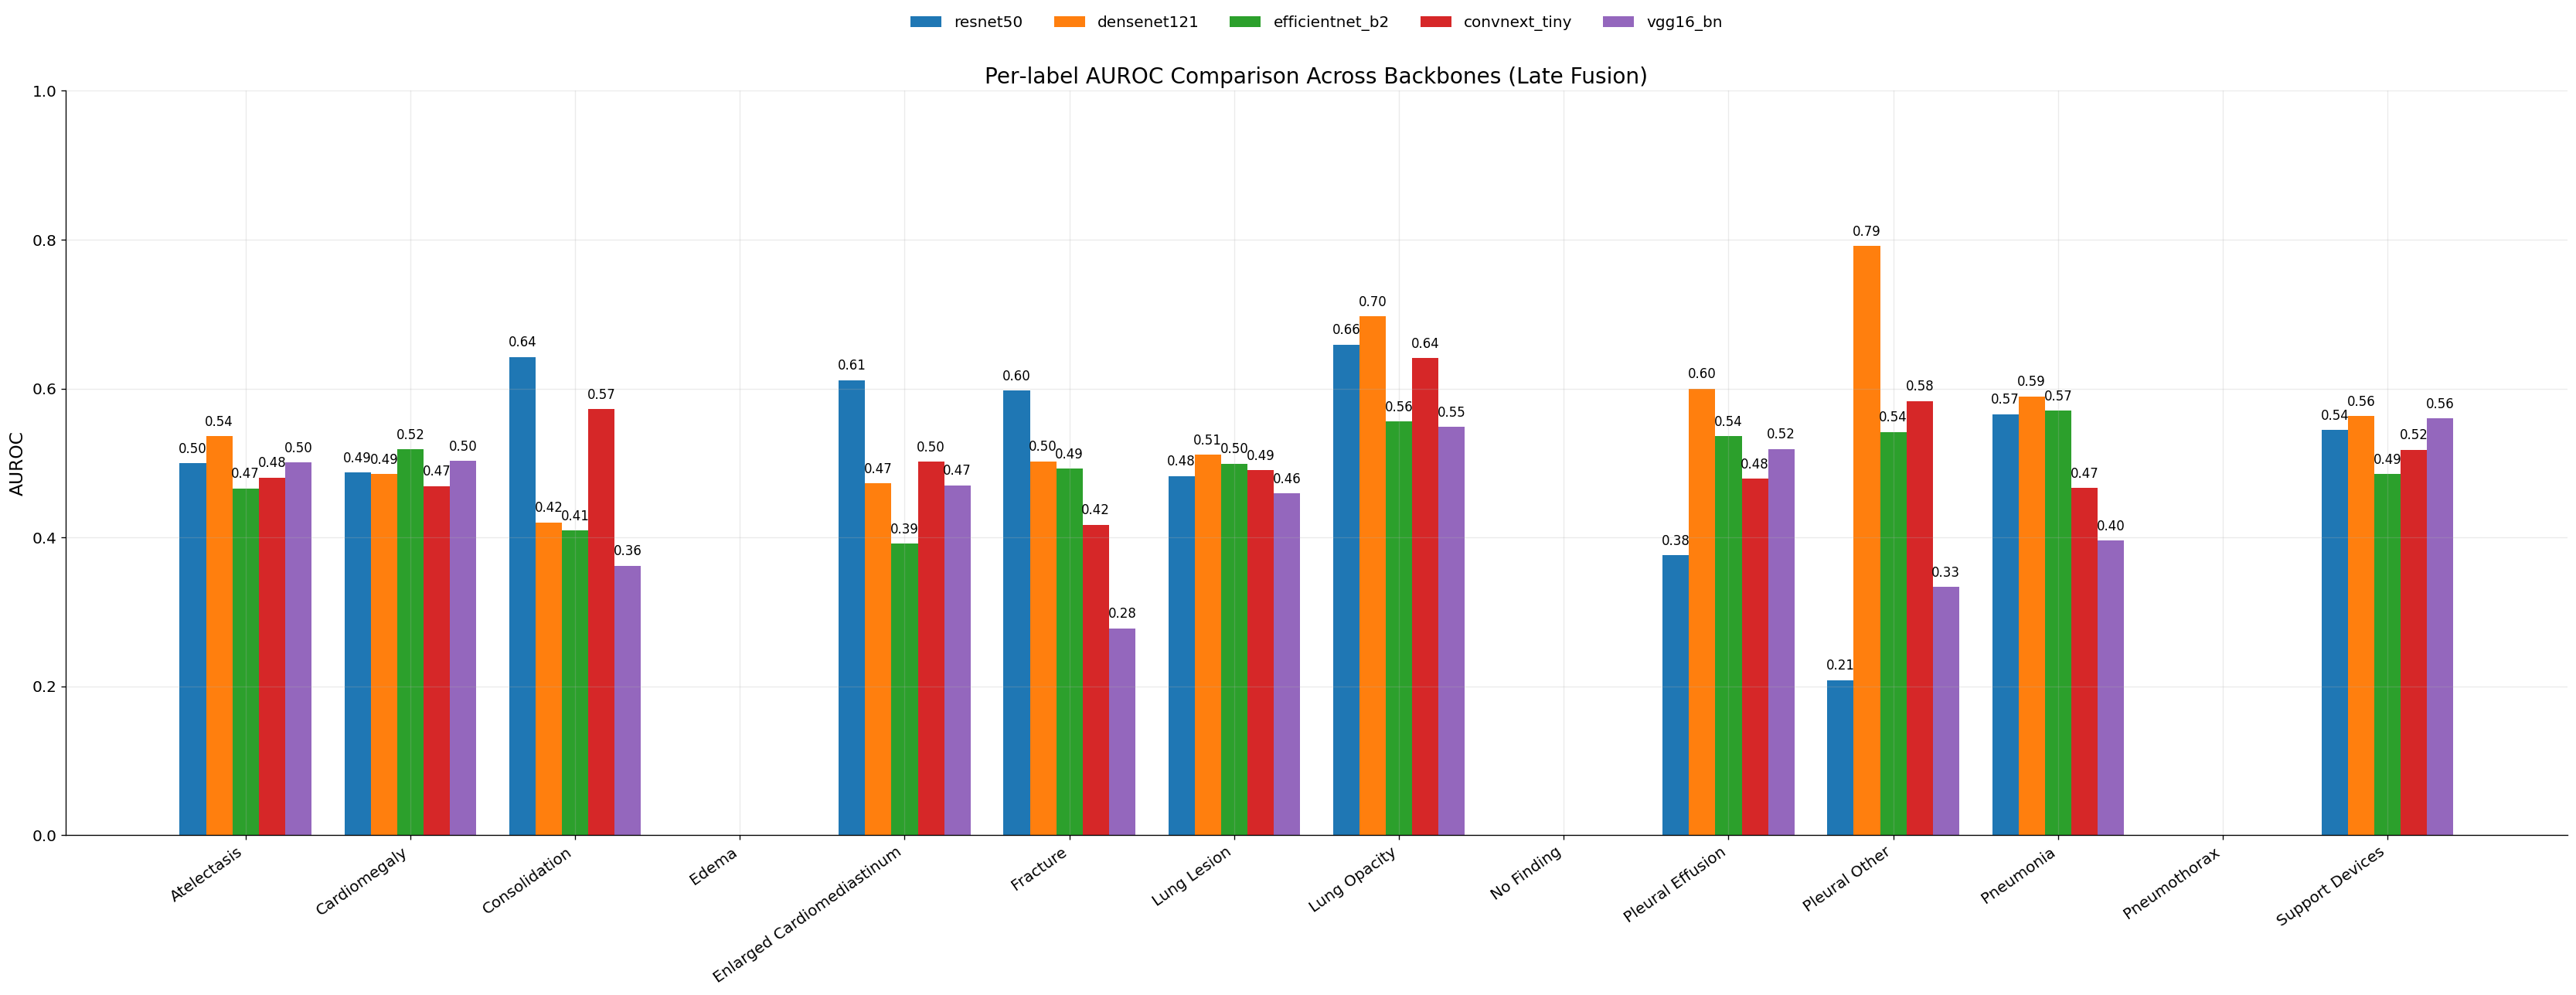

Saved: ./checkpoints/eval_late/per_label_auroc_comparison_across_backbones_late.png

Topline summary (macro AUROC desc):


,backbone,macro_auroc,flat_auroc,eval_sec,eval_peak_gpu_GB
1,densenet121,0.560777,0.824988,1.491758,0.420928
0,resnet50,0.515780,0.821872,1.672294,0.570010
3,convnext_tiny,0.510641,0.823822,1.619873,0.654087
2,efficientnet_b2,0.496758,0.727722,1.221165,0.440433
4,vgg16_bn,0.448045,0.774451,2.197086,1.414354


In [ ]:
# === eval_late_fusion.py  ===
import os, time, math, json
import numpy as np
import pandas as pd
import torch
from sklearn.metrics import roc_auc_score, f1_score
import matplotlib.pyplot as plt

from dataloader import get_dataloaders
from late_fusion_multibackbone import LateFusionClassifier  

SAVE_DIR = "./checkpoints"         
EVAL_DIR = os.path.join(SAVE_DIR, "eval_late")
os.makedirs(EVAL_DIR, exist_ok=True)

# ---- labels ----
LABELS = [
    "Atelectasis","Cardiomegaly","Consolidation","Edema","Enlarged Cardiomediastinum",
    "Fracture","Lung Lesion","Lung Opacity","No Finding","Pleural Effusion",
    "Pleural Other","Pneumonia","Pneumothorax","Support Devices"
]

BACKBONES = ["resnet50","densenet121","efficientnet_b2","convnext_tiny","vgg16_bn"]
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# -----------------------------
# Metrics helpers
# -----------------------------
def masked_per_label_auroc(y_true, y_prob):
    """Per-label AUROC with CheXpert -1 masking; returns array of shape (C,) with NaN where undefined."""
    y_true = y_true.copy()
    y_prob = y_prob.copy()
    C = y_true.shape[1]
    out = np.full(C, np.nan, dtype=float)
    for c in range(C):
        m = (y_true[:, c] != -1)
        if m.sum() == 0: 
            continue
        yt = y_true[m, c].astype(np.int32)
        yp = y_prob[m, c]
        if yt.max() == yt.min():  # only one class present
            continue
        out[c] = roc_auc_score(yt, yp)
    return out

def macro_auroc(y_true, y_prob):
    vals = masked_per_label_auroc(y_true, y_prob)
    return float(np.nanmean(vals))

def flat_auroc(y_true, y_prob):
    m = (y_true != -1)
    yt = y_true[m].astype(np.int32)
    yp = y_prob[m]
    return float(roc_auc_score(yt, yp))

def per_label_f1(y_true, y_prob, thresh=0.5):
    """Per-label F1 with masking; returns array of shape (C,) with NaN if undefined."""
    C = y_true.shape[1]
    out = np.full(C, np.nan, dtype=float)
    for c in range(C):
        m = (y_true[:, c] != -1)
        if m.sum() == 0:
            continue
        yt = y_true[m, c].astype(np.int32)
        yp = (y_prob[m, c] >= thresh).astype(np.int32)
        if yt.max() == yt.min():  # only one class present
            continue
        out[c] = f1_score(yt, yp)
    return out

# -----------------------------
# Evaluate one backbone
# -----------------------------
def evaluate_backbone(backbone, data_dir, lab_input_dim=100, batch_size=16, num_workers=4):
    ckpt_path = os.path.join(SAVE_DIR, f"late_fusion_{backbone}.pt")
    assert os.path.exists(ckpt_path), f"Missing checkpoint: {ckpt_path}"

    # build model & load weights
    model = LateFusionClassifier(num_classes=len(LABELS), lr=1e-4,
                                 lab_input_dim=lab_input_dim, cxr_backbone=backbone).to(DEVICE)
    state = torch.load(ckpt_path, map_location=DEVICE)
    model.load_state_dict(state)
    model.eval()

    # test loader
    _, _, test_loader = get_dataloaders(data_dir, batch_size=batch_size, num_workers=num_workers)

    # collect
    probs_all, targs_all = [], []
    t0 = time.perf_counter()
    if torch.cuda.is_available():
        torch.cuda.reset_peak_memory_stats()

    with torch.no_grad():
        for cxr, ecg, labs, y in test_loader:
            cxr  = cxr.to(DEVICE).float()
            labs = labs.to(DEVICE).float()
            y    = y.to(DEVICE)

            # Coerce ECG to (B,12,T)
            ecg = ecg.to(DEVICE).float()
            if ecg.ndim == 4 and ecg.shape[1] == 1:
                ecg = ecg.squeeze(1)
            if ecg.shape[1] != 12 and ecg.shape[-1] == 12:
                ecg = ecg.permute(0, 2, 1)

            logits = model(cxr, ecg, labs)
            probs_all.append(torch.sigmoid(logits).cpu().numpy())
            targs_all.append(y.cpu().numpy())

    eval_sec = time.perf_counter() - t0
    eval_peak_gb = (torch.cuda.max_memory_allocated() / 1e9) if torch.cuda.is_available() else 0.0

    y_prob = np.concatenate(probs_all, axis=0)
    y_true = np.concatenate(targs_all, axis=0)

    # metrics
    per_auc = masked_per_label_auroc(y_true, y_prob)
    per_f1  = per_label_f1(y_true, y_prob, thresh=0.5)
    macro   = macro_auroc(y_true, y_prob)
    flat    = flat_auroc(y_true, y_prob)

    # save per-backbone CSV
    df = pd.DataFrame({
        "label": LABELS,
        "auroc": per_auc,
        "f1":    per_f1,
    })
    out_csv = os.path.join(EVAL_DIR, f"per_label_{backbone}.csv")
    df.to_csv(out_csv, index=False)

    return {
        "backbone": backbone,
        "per_label_auroc": per_auc,
        "per_label_f1": per_f1,
        "macro_auroc": macro,
        "flat_auroc": flat,
        "eval_sec": eval_sec,
        "eval_peak_gpu_GB": eval_peak_gb,
        "per_label_csv": out_csv,
    }

# -----------------------------
# Run evaluation for all backbones
# -----------------------------
def run_eval_all(backbones, data_dir, lab_input_dim=100, batch_size=16, num_workers=4):
    results = []
    for b in backbones:
        print(f"Evaluating {b} …")
        res = evaluate_backbone(b, data_dir, lab_input_dim, batch_size, num_workers)
        results.append(res)

    # Combined summary table (macro/flat + eval cost)
    summary_rows = []
    for r in results:
        summary_rows.append({
            "backbone": r["backbone"],
            "macro_auroc": r["macro_auroc"],
            "flat_auroc": r["flat_auroc"],
            "eval_sec": r["eval_sec"],
            "eval_peak_gpu_GB": r["eval_peak_gpu_GB"],
        })
    summary_df = pd.DataFrame(summary_rows).sort_values("macro_auroc", ascending=False)
    summary_csv = os.path.join(EVAL_DIR, "late_summary_overall.csv")
    summary_df.to_csv(summary_csv, index=False)
    print(f"Saved overall summary → {summary_csv}")

    # Per-label combined table and bold‑best for markdown export
    # Build a data frame: rows=label, cols=backbones (AUROC), then +F1 cols if wanted
    auc_mat = {}
    f1_mat = {}
    for r in results:
        auc_mat[r["backbone"]] = r["per_label_auroc"]
        f1_mat[r["backbone"]]  = r["per_label_f1"]
    auc_df = pd.DataFrame(auc_mat, index=LABELS)
    f1_df  = pd.DataFrame(f1_mat,  index=LABELS)

    auc_path = os.path.join(EVAL_DIR, "per_label_auroc_all.csv")
    f1_path  = os.path.join(EVAL_DIR, "per_label_f1_all.csv")
    auc_df.to_csv(auc_path)
    f1_df.to_csv(f1_path)
    print(f"Saved per‑label AUROC table → {auc_path}")
    print(f"Saved per‑label F1 table   → {f1_path}")

    # Markdown‑friendly with bold best per label (AUROC)
    md_lines = ["| Label | " + " | ".join(backbones) + " |",
                "|" + " --- |" * (len(backbones)+1)]
    for lbl in LABELS:
        row = auc_df.loc[lbl].values.astype(float)
        best = np.nanmax(row)
        cells = []
        for v in row:
            if np.isnan(v):
                cells.append("—")
            elif abs(v - best) < 1e-12:
                cells.append(f"**{v:.3f}**")
            else:
                cells.append(f"{v:.3f}")
        md_lines.append("| " + lbl + " | " + " | ".join(cells) + " |")
    md_text = "\n".join(md_lines)
    with open(os.path.join(EVAL_DIR, "per_label_auroc_all.md"), "w") as f:
        f.write(md_text)

    return results, summary_df, auc_df, f1_df

# -----------------------------
# Big per‑label AUROC comparison bar chart (across backbones)
# -----------------------------
def plot_per_label_auroc_across_backbones(auc_df, out_png):
    # auc_df: index=LABELS, columns=BACKBONES
    plt.rcParams.update({
        "figure.dpi": 120,
        "font.size": 14,
        "xtick.labelsize": 12,
        "ytick.labelsize": 12,
        "legend.fontsize": 12,
        "axes.grid": True, "grid.alpha": 0.25,
        "axes.spines.top": False, "axes.spines.right": False,
    })

    labels = auc_df.index.tolist()
    backbones = auc_df.columns.tolist()
    n_labels = len(labels)
    n_bb = len(backbones)
    x = np.arange(n_labels)
    width = 0.8 / n_bb

    fig, ax = plt.subplots(figsize=(28, 11))
    for i, b in enumerate(backbones):
        vals = auc_df[b].values.astype(float)
        off = (i - (n_bb-1)/2) * width
        bars = ax.bar(x + off, vals, width=width, label=b)
        # annotate small value above each bar
        for rect, v in zip(bars, vals):
            if not np.isnan(v):
                ax.text(rect.get_x() + rect.get_width()/2, rect.get_height()+0.01,
                        f"{v:.2f}", ha="center", va="bottom", fontsize=10, rotation=0)

    ax.set_ylim(0.0, 1.0)
    ax.set_ylabel("AUROC")
    ax.set_title("Per‑label AUROC Comparison Across Backbones (Late Fusion)")
    ax.set_xticks(x)
    ax.set_xticklabels(labels, rotation=35, ha="right")
    ax.legend(ncols=min(5, n_bb), loc="upper center", bbox_to_anchor=(0.5, 1.12), frameon=False)

    fig.tight_layout()
    fig.savefig(out_png, dpi=220, bbox_inches="tight")
    plt.show()
    print(f"Saved: {out_png}")

# -----------------------------
# RUN
# -----------------------------
DATA_DIR = "/data/mahjabeen_workspace/Summer25_Project/symile/new_experiment/symile_fusion_classification/data/processed_pt_correctedV2"

results, summary_df, auc_df, f1_df = run_eval_all(
    BACKBONES, data_dir=DATA_DIR, lab_input_dim=100, batch_size=16, num_workers=4
)

plot_per_label_auroc_across_backbones(
    auc_df, out_png=os.path.join(EVAL_DIR, "per_label_auroc_comparison_across_backbones_late.png")
)

print("\nTopline summary (macro AUROC desc):")
display(summary_df)
